In [53]:
import tensorflow as tf
tf.__version__
tf.config.experimental.enable_op_determinism()
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)

In [54]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt
import random

In [55]:
def plot_columns(df):
    colors = plt.cm.tab20(range(df.shape[1]))  

    for i, column in enumerate(df.columns):
        color = colors[i % 24]

        plt.figure()
        plt.plot(df.index, df[column], color=color)
        plt.xlabel('Tempo')
        plt.ylabel('Valor')
        plt.title(column)

    plt.show()

In [56]:
def plot_correlation_matrix(df):
    correlation_matrix = df.corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title("Correlation Matrix Heatmap")
    plt.show()

In [57]:
tf.keras.backend.clear_session()

In [58]:
subject = 'Sergipe - Consumo de Cimento (t)'
start_index = 0
split_index = 179
window_size = 36
train_split = split_index + 1 - 12

In [59]:
data = pd.read_csv('2003_mo_model_input_SE.csv')
pd.set_option('display.max_columns', None)
data

,Unnamed: 0,Sergipe- custo m2 (R$),Sergipe - IDH Educacao,Sergipe - IDH,Sergipe - Depósito Poupança (R$),Sergipe - IDH Longevidade,Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Sergipe - value,Sergipe - Produção de Cimento (t),Sergipe - Consumo de Cimento (t),Sergipe - PIB - Estadual,Sergipe - PIB - Construção Civil,Sergipe - PIB - Per Capita,Sergipe - PIB - Preços de Mercado,Sergipe - IDH Renda,Sergipe - Desemprego,Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%)
0,2003-1,9513.254800,0.599319,0.669217,1.618045e+06,0.750379,1.154340,1013.090299,2716.496979,26.501337,23.889841,80.366597,3.552746,0.339447,152.791400,23.616,2.159732e+07,1.260978e+06,9.960678,2.029642e+07,0.648121,8.389943,384683.093871,7.330309e+06,231.510748,2.097001e+06,1.036534,3.656420,0.969649,0.724032,-5331.049150,11.520143,126.459809,1.772069e+08,169.247665,1.611498
1,2003-2,9606.199031,0.599716,0.669542,1.622416e+06,0.750793,1.155152,1013.092341,2716.496979,26.502125,23.879336,80.334711,3.551254,0.341257,151.964054,21.357,2.162153e+07,1.262134e+06,9.961956,2.030238e+07,0.648377,8.384067,385266.203928,7.335910e+06,208.710157,2.000523e+06,0.993449,3.654697,0.950783,0.690297,-5318.079644,11.189862,126.581813,1.773884e+08,170.176810,1.450389
2,2003-3,9693.715697,0.600113,0.669868,1.626787e+06,0.751207,1.155625,1013.093533,2716.496979,26.502585,23.873208,80.316112,3.550384,0.343016,154.467758,20.059,2.164574e+07,1.263289e+06,9.963234,2.030833e+07,0.648633,8.378190,385305.059560,7.341511e+06,227.704841,1.963278e+06,0.973020,3.654266,0.938332,0.669681,-5436.417870,10.820792,126.703818,1.775699e+08,171.135713,1.870184
3,2003-4,9777.797840,0.600511,0.670193,1.631158e+06,0.751620,1.155676,1013.093660,2716.496979,26.502635,23.872551,80.314119,3.550291,0.344722,155.913400,19.920,2.166995e+07,1.264444e+06,9.964512,2.031429e+07,0.648889,8.372313,385752.052697,7.347112e+06,278.121073,1.954187e+06,0.940489,3.653595,0.926401,0.660494,-5707.015274,10.417840,126.825822,1.777514e+08,172.116904,1.355287
4,2003-5,9852.699220,0.600908,0.670519,1.635529e+06,0.752034,1.195157,1012.797543,2575.798720,26.636934,23.787977,79.846291,3.554977,0.346174,157.467159,19.962,2.169416e+07,1.265599e+06,9.965790,2.032025e+07,0.649145,8.366437,387164.022451,7.352713e+06,344.827633,1.975493e+06,0.917493,3.650266,0.951683,0.648337,-5599.317941,9.959690,126.976217,1.779329e+08,173.072271,1.585538
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
244,2023-5,33548.705040,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
245,2023-6,33497.662935,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
246,2023-7,33431.682561,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
247,2023-8,33345.640179,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


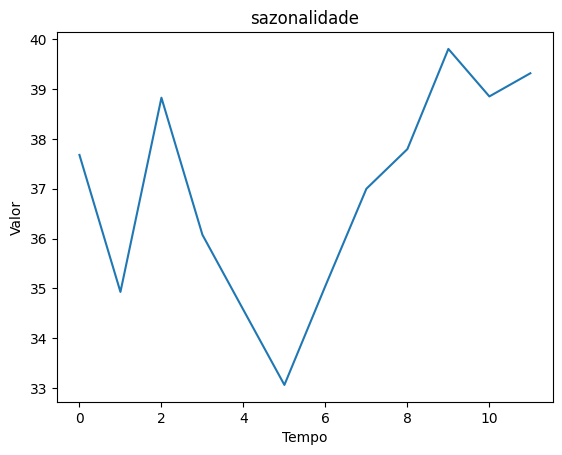

,sazonalidade
sazonalidade,
0,37.680295
1,34.927623
2,38.830336
3,36.075924
4,34.565679
5,33.058726
6,35.048581
7,37.000561
8,37.797166


In [60]:
def calculate_monthly_means(consume_of_cement, subject):
    df = pd.DataFrame({subject: consume_of_cement[:train_split]})
    df['sazonalidade'] = df.index % 12
    monthly_means = df.groupby('sazonalidade')[subject].mean()
    result_df = pd.DataFrame({'sazonalidade': monthly_means})

    return result_df

media_df = calculate_monthly_means(data[subject], subject)
plot_columns(media_df)
media_df

In [61]:
def fill_original_df_with_monthly_means(df_og, media_df):
    monthly_means = media_df['sazonalidade'].tolist()
    df_og['sazonalidade'] = [monthly_means[i % 12] for i in range(len(df_og))]
    return df_og

data = fill_original_df_with_monthly_means(data, media_df)
data = data[[col for col in data.columns if col != subject] + [subject]] #Seta consumo (target) para a coluna final
data

,Unnamed: 0,Sergipe- custo m2 (R$),Sergipe - IDH Educacao,Sergipe - IDH,Sergipe - Depósito Poupança (R$),Sergipe - IDH Longevidade,Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Sergipe - value,Sergipe - Produção de Cimento (t),Sergipe - PIB - Estadual,Sergipe - PIB - Construção Civil,Sergipe - PIB - Per Capita,Sergipe - PIB - Preços de Mercado,Sergipe - IDH Renda,Sergipe - Desemprego,Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%),sazonalidade,Sergipe - Consumo de Cimento (t)
0,2003-1,9513.254800,0.599319,0.669217,1.618045e+06,0.750379,1.154340,1013.090299,2716.496979,26.501337,23.889841,80.366597,3.552746,0.339447,152.791400,2.159732e+07,1.260978e+06,9.960678,2.029642e+07,0.648121,8.389943,384683.093871,7.330309e+06,231.510748,2.097001e+06,1.036534,3.656420,0.969649,0.724032,-5331.049150,11.520143,126.459809,1.772069e+08,169.247665,1.611498,37.680295,23.616
1,2003-2,9606.199031,0.599716,0.669542,1.622416e+06,0.750793,1.155152,1013.092341,2716.496979,26.502125,23.879336,80.334711,3.551254,0.341257,151.964054,2.162153e+07,1.262134e+06,9.961956,2.030238e+07,0.648377,8.384067,385266.203928,7.335910e+06,208.710157,2.000523e+06,0.993449,3.654697,0.950783,0.690297,-5318.079644,11.189862,126.581813,1.773884e+08,170.176810,1.450389,34.927623,21.357
2,2003-3,9693.715697,0.600113,0.669868,1.626787e+06,0.751207,1.155625,1013.093533,2716.496979,26.502585,23.873208,80.316112,3.550384,0.343016,154.467758,2.164574e+07,1.263289e+06,9.963234,2.030833e+07,0.648633,8.378190,385305.059560,7.341511e+06,227.704841,1.963278e+06,0.973020,3.654266,0.938332,0.669681,-5436.417870,10.820792,126.703818,1.775699e+08,171.135713,1.870184,38.830336,20.059
3,2003-4,9777.797840,0.600511,0.670193,1.631158e+06,0.751620,1.155676,1013.093660,2716.496979,26.502635,23.872551,80.314119,3.550291,0.344722,155.913400,2.166995e+07,1.264444e+06,9.964512,2.031429e+07,0.648889,8.372313,385752.052697,7.347112e+06,278.121073,1.954187e+06,0.940489,3.653595,0.926401,0.660494,-5707.015274,10.417840,126.825822,1.777514e+08,172.116904,1.355287,36.075924,19.920
4,2003-5,9852.699220,0.600908,0.670519,1.635529e+06,0.752034,1.195157,1012.797543,2575.798720,26.636934,23.787977,79.846291,3.554977,0.346174,157.467159,2.169416e+07,1.265599e+06,9.965790,2.032025e+07,0.649145,8.366437,387164.022451,7.352713e+06,344.827633,1.975493e+06,0.917493,3.650266,0.951683,0.648337,-5599.317941,9.959690,126.976217,1.779329e+08,173.072271,1.585538,34.565679,19.962
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
244,2023-5,33548.705040,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,34.565679,NaN
245,2023-6,33497.662935,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,33.058726,NaN
246,2023-7,33431.682561,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,35.048581,NaN
247,2023-8,33345.640179,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,37.000561,NaN


In [62]:
# Shift para prever futuro e não presente
target_data = data[subject].shift(-24)
target_data

0      18.244
1      18.161
2      23.259
3      19.137
4      15.066
        ...  
244       NaN
245       NaN
246       NaN
247       NaN
248       NaN
Name: Sergipe - Consumo de Cimento (t), Length: 249, dtype: float64

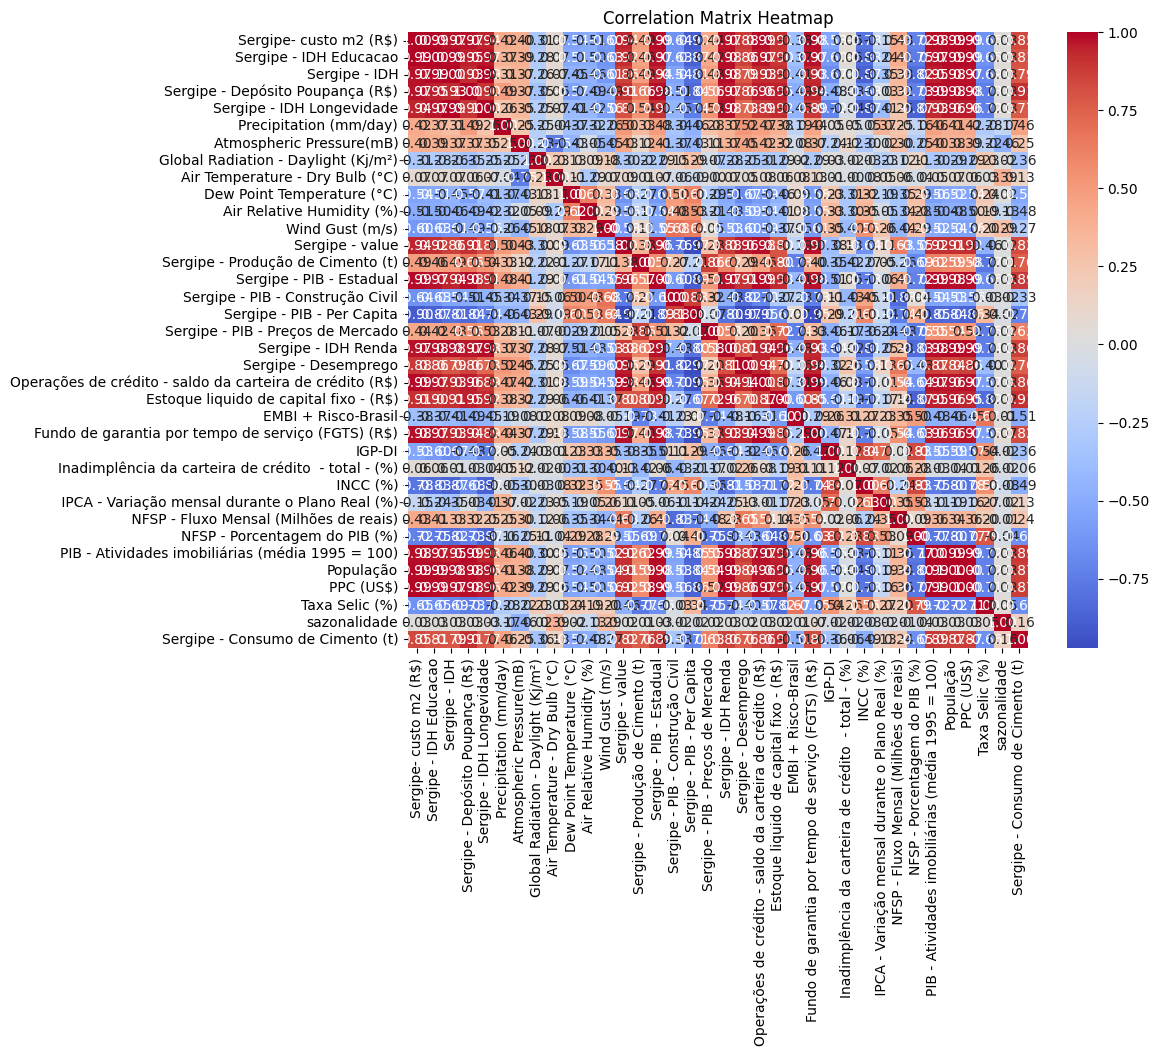

In [63]:
plot_data = data.iloc[:split_index + 1,1:]
plot_correlation_matrix(plot_data)

In [64]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

safe_data = data.iloc[:split_index + 1,1:-1]

def calculate_vif(dataframe):
    vif_data = pd.DataFrame()
    vif_data["Feature"] = dataframe.columns
    vif_data["VIF"] = [variance_inflation_factor(dataframe.values, i) for i in range(dataframe.shape[1])]
    return vif_data

def remove_high_vif_columns(dataframe, threshold=1000):
    i=0
    while True:
        vif_result = calculate_vif(dataframe)
        high_vif_column = vif_result.loc[vif_result["VIF"].idxmax()]["Feature"]
        
        if vif_result["VIF"].max() <= threshold:
            print(f"Num columns removed: {i}")
            return dataframe
        i += 1
        dataframe = dataframe.drop(high_vif_column, axis=1)

In [65]:
safe_data = data.iloc[:split_index + 1,1:-1]
vif_info = calculate_vif(safe_data)
vif_info

,Feature,VIF
0,Sergipe- custo m2 (R$),3.961181e+06
1,Sergipe - IDH Educacao,1.680808e+09
2,Sergipe - IDH,5.714224e+09
3,Sergipe - Depósito Poupança (R$),1.572386e+05
4,Sergipe - IDH Longevidade,3.005087e+09
5,Precipitation (mm/day),5.635222e+01
6,Atmospheric Pressure(mB),1.354186e+07
7,Global Radiation - Daylight (Kj/m²),8.670571e+00
8,Air Temperature - Dry Bulb (°C),3.552687e+04
9,Dew Point Temperature (°C),5.708841e+02


In [66]:
data = remove_high_vif_columns(safe_data, 100000000)
data

Num columns removed: 3


,Sergipe- custo m2 (R$),Sergipe - IDH Educacao,Sergipe - Depósito Poupança (R$),Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Sergipe - value,Sergipe - Produção de Cimento (t),Sergipe - PIB - Estadual,Sergipe - PIB - Construção Civil,Sergipe - PIB - Per Capita,Sergipe - IDH Renda,Sergipe - Desemprego,Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%),sazonalidade
0,9513.254800,0.599319,1.618045e+06,1.154340,1013.090299,2716.496979,26.501337,23.889841,80.366597,3.552746,0.339447,152.791400,2.159732e+07,1.260978e+06,9.960678,0.648121,8.389943,3.846831e+05,7.330309e+06,231.510748,2.097001e+06,1.036534,3.656420,0.969649,0.724032,-5331.049150,11.520143,126.459809,1.772069e+08,169.247665,1.611498,37.680295
1,9606.199031,0.599716,1.622416e+06,1.155152,1013.092341,2716.496979,26.502125,23.879336,80.334711,3.551254,0.341257,151.964054,2.162153e+07,1.262134e+06,9.961956,0.648377,8.384067,3.852662e+05,7.335910e+06,208.710157,2.000523e+06,0.993449,3.654697,0.950783,0.690297,-5318.079644,11.189862,126.581813,1.773884e+08,170.176810,1.450389,34.927623
2,9693.715697,0.600113,1.626787e+06,1.155625,1013.093533,2716.496979,26.502585,23.873208,80.316112,3.550384,0.343016,154.467758,2.164574e+07,1.263289e+06,9.963234,0.648633,8.378190,3.853051e+05,7.341511e+06,227.704841,1.963278e+06,0.973020,3.654266,0.938332,0.669681,-5436.417870,10.820792,126.703818,1.775699e+08,171.135713,1.870184,38.830336
3,9777.797840,0.600511,1.631158e+06,1.155676,1013.093660,2716.496979,26.502635,23.872551,80.314119,3.550291,0.344722,155.913400,2.166995e+07,1.264444e+06,9.964512,0.648889,8.372313,3.857521e+05,7.347112e+06,278.121073,1.954187e+06,0.940489,3.653595,0.926401,0.660494,-5707.015274,10.417840,126.825822,1.777514e+08,172.116904,1.355287,36.075924
4,9852.699220,0.600908,1.635529e+06,1.195157,1012.797543,2575.798720,26.636934,23.787977,79.846291,3.554977,0.346174,157.467159,2.169416e+07,1.265599e+06,9.965790,0.649145,8.366437,3.871640e+05,7.352713e+06,344.827633,1.975493e+06,0.917493,3.650266,0.951683,0.648337,-5599.317941,9.959690,126.976217,1.779329e+08,173.072271,1.585538,34.565679
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,22452.866144,0.654086,3.629906e+06,1.623080,1015.695518,1299.193922,25.714356,19.131620,67.582125,1.463442,0.465001,176.557134,2.495171e+07,1.201196e+06,9.826200,0.672533,13.674967,3.068648e+06,7.783063e+06,273.655482,1.001735e+07,0.471521,3.683580,0.378150,0.366904,-5783.316460,2.206994,196.778355,1.987710e+08,416.859692,0.583985,37.000561
176,22520.590973,0.654195,3.645354e+06,1.538460,1015.003687,1379.199971,25.999863,19.447600,67.755788,1.997834,0.463900,176.140993,2.494830e+07,1.200540e+06,9.826782,0.672458,13.667766,3.070265e+06,7.780841e+06,269.131737,9.868983e+06,0.476827,3.634735,0.377666,0.358935,-6001.730740,2.215328,197.255170,1.988450e+08,417.748887,0.753312,37.797166
177,22586.747475,0.654303,3.660802e+06,1.398794,1014.063522,1470.634310,26.467409,19.757808,67.176703,2.536764,0.462770,175.707193,2.494490e+07,1.199884e+06,9.827364,0.672382,13.660565,3.078615e+06,7.778619e+06,265.863958,1.025520e+07,0.475427,3.545663,0.377838,0.354313,-6454.887704,2.232466,197.731985,1.989190e+08,418.601189,0.882343,39.810563
178,22653.542283,0.654412,3.676249e+06,1.570446,1013.248109,1516.937909,26.826490,20.128342,67.306312,2.792457,0.461552,174.879535,2.494149e+07,1.199229e+06,9.827946,0.672307,13.653364,3.083099e+06,7.776397e+06,263.7410

In [67]:
input_data = data.iloc[:split_index + 1,1:]
mean = np.mean(input_data, axis=0)
stddev =  np.std(input_data, axis=0)
input_data = ((input_data - mean) /stddev)
# scaler=MinMaxScaler()
# scaled_data = scaler.fit_transform(input_data)
# input_data = pd.DataFrame(scaled_data, columns=input_data.columns)
input_data

,Sergipe - IDH Educacao,Sergipe - Depósito Poupança (R$),Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Sergipe - value,Sergipe - Produção de Cimento (t),Sergipe - PIB - Estadual,Sergipe - PIB - Construção Civil,Sergipe - PIB - Per Capita,Sergipe - IDH Renda,Sergipe - Desemprego,Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%),sazonalidade
0,-1.859889,-1.565588,-0.559877,-0.463888,0.013800,-0.274588,0.990699,0.923044,0.643537,-1.264661,-1.735466,-1.713206,-0.378558,0.493840,-2.167321,-0.793096,-1.310937,-2.299937,-0.582539,-1.302390,3.921218,1.209036,3.214079,2.802383,0.604311,4.268118,-1.845112,-2.016914,-1.798021,2.127040,0.369663
1,-1.834268,-1.559589,-0.558009,-0.462265,0.013800,-0.273441,0.986645,0.919261,0.641899,-1.229611,-1.757716,-1.691835,-0.345145,0.512856,-2.132001,-0.795484,-1.310358,-2.263992,-0.792841,-1.336546,3.582946,1.203470,3.051841,2.402642,0.609431,4.096014,-1.839712,-1.988421,-1.785942,1.562580,-0.958950
2,-1.808647,-1.553590,-0.556920,-0.461319,0.013800,-0.272772,0.984280,0.917054,0.640944,-1.195546,-1.690385,-1.670465,-0.311731,0.531873,-2.096681,-0.797872,-1.310320,-2.228047,-0.617643,-1.349731,3.422548,1.202078,2.944772,2.158351,0.562720,3.903698,-1.834313,-1.959928,-1.773475,3.033368,0.924745
3,-1.783026,-1.547592,-0.556803,-0.461218,0.013800,-0.272700,0.984026,0.916818,0.640841,-1.162500,-1.651508,-1.649094,-0.278318,0.550890,-2.061361,-0.800260,-1.309876,-2.192102,-0.152627,-1.352950,3.167136,1.199914,2.842174,2.049492,0.455907,3.693727,-1.828913,-1.931435,-1.760719,1.229384,-0.404707
4,-1.757405,-1.541593,-0.465958,-0.696394,-0.017584,-0.077337,0.951387,0.861316,0.645989,-1.134378,-1.609723,-1.627724,-0.244904,0.569907,-2.026041,-0.802647,-1.308476,-2.156157,0.462644,-1.345407,2.986591,1.189162,3.059587,1.905441,0.498418,3.454992,-1.822257,-1.902941,-1.748299,2.036088,-1.133647
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,1.671820,1.195524,0.518693,1.605172,-0.302341,-1.419397,-0.845616,-0.593673,-1.651143,1.166644,-1.096345,1.247832,-2.107812,-1.507441,1.199933,1.354253,1.351069,0.605679,-0.193815,1.501633,-0.514871,1.296737,-1.872446,-1.429358,0.425789,-0.584804,1.266999,1.368581,1.421090,-1.472938,0.041581
176,1.678819,1.216724,0.323982,1.055721,-0.284495,-1.004075,-0.723672,-0.573070,-1.064221,1.145333,-1.107536,1.244826,-2.126777,-1.498780,1.189546,1.351327,1.352673,0.591420,-0.235540,1.449107,-0.473208,1.139013,-1.876611,-1.523783,0.339575,-0.580461,1.288102,1.380202,1.432650,-0.879688,0.426072
177,1.685818,1.237925,0.002611,0.309045,-0.264100,-0.323942,-0.603955,-0.641771,-0.472314,1.123449,-1.119202,1.241820,-2.145741,-1.490118,1.179159,1.348402,1.360954,0.577161,-0.265681,1.585840,-0.484199,0.851392,-1.875135,-1.578548,0.160702,-0.571531,1.309204,1.391823,1.443731,-0.427616,1.397865
178,1.692817,1.259125,0.397580,-0.338555,-0.253771,0.198407,-0.460957,-0.626395,-0.191487,1.099866,-1.141460,1.238814,-2.164706,-1.481457,1.168773,1.345476,1.365401,0.562902,-0.285262,1.756179,-0.359568,0.626702,-1.942040,-1.597335,0.244264,-0.555524,1.330436,1.403443,1.454507,-0.000772,0.937097


In [68]:
# input para treinamento
train_input = input_data.iloc[start_index:train_split]
train_input

,Sergipe - IDH Educacao,Sergipe - Depósito Poupança (R$),Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Sergipe - value,Sergipe - Produção de Cimento (t),Sergipe - PIB - Estadual,Sergipe - PIB - Construção Civil,Sergipe - PIB - Per Capita,Sergipe - IDH Renda,Sergipe - Desemprego,Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%),sazonalidade
0,-1.859889,-1.565588,-0.559877,-0.463888,0.013800,-0.274588,0.990699,0.923044,0.643537,-1.264661,-1.735466,-1.713206,-0.378558,0.493840,-2.167321,-0.793096,-1.310937,-2.299937,-0.582539,-1.302390,3.921218,1.209036,3.214079,2.802383,0.604311,4.268118,-1.845112,-2.016914,-1.798021,2.127040,0.369663
1,-1.834268,-1.559589,-0.558009,-0.462265,0.013800,-0.273441,0.986645,0.919261,0.641899,-1.229611,-1.757716,-1.691835,-0.345145,0.512856,-2.132001,-0.795484,-1.310358,-2.263992,-0.792841,-1.336546,3.582946,1.203470,3.051841,2.402642,0.609431,4.096014,-1.839712,-1.988421,-1.785942,1.562580,-0.958950
2,-1.808647,-1.553590,-0.556920,-0.461319,0.013800,-0.272772,0.984280,0.917054,0.640944,-1.195546,-1.690385,-1.670465,-0.311731,0.531873,-2.096681,-0.797872,-1.310320,-2.228047,-0.617643,-1.349731,3.422548,1.202078,2.944772,2.158351,0.562720,3.903698,-1.834313,-1.959928,-1.773475,3.033368,0.924745
3,-1.783026,-1.547592,-0.556803,-0.461218,0.013800,-0.272700,0.984026,0.916818,0.640841,-1.162500,-1.651508,-1.649094,-0.278318,0.550890,-2.061361,-0.800260,-1.309876,-2.192102,-0.152627,-1.352950,3.167136,1.199914,2.842174,2.049492,0.455907,3.693727,-1.828913,-1.931435,-1.760719,1.229384,-0.404707
4,-1.757405,-1.541593,-0.465958,-0.696394,-0.017584,-0.077337,0.951387,0.861316,0.645989,-1.134378,-1.609723,-1.627724,-0.244904,0.569907,-2.026041,-0.802647,-1.308476,-2.156157,0.462644,-1.345407,2.986591,1.189162,3.059587,1.905441,0.498418,3.454992,-1.822257,-1.902941,-1.748299,2.036088,-1.133647
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163,1.559404,0.983942,-0.503420,1.392318,-0.275711,-0.495972,-0.837180,-0.885207,-2.843564,1.456089,-0.586003,1.250730,-1.774120,-1.618367,1.305879,1.409300,1.407354,0.759879,0.731931,1.338281,-1.087000,1.252487,-1.491033,-0.960452,1.465326,-0.676734,1.091879,1.228701,1.261902,0.499090,0.041581
164,1.572089,0.996577,-0.425721,0.832431,-0.257837,-0.164691,-0.723802,-0.854707,-2.936060,1.429345,-0.645960,1.254359,-1.814307,-1.608308,1.299232,1.402387,1.402136,0.749001,0.583095,1.318191,-0.904679,1.414483,-1.525186,-1.007966,1.351131,-0.668750,1.100438,1.240408,1.276272,0.323875,0.426072
165,1.584774,1.009213,-0.612838,0.271401,-0.242913,0.289931,-0.657583,-0.915893,-2.985676,1.401562,-0.701322,1.257987,-1.854495,-1.598249,1.292584,1.395474,1.398719,0.738124,0.433167,1.483470,-0.900134,1.498244,-1.546744,-0.976556,1.143146,-0.657609,1.108997,1.252114,1.290351,0.198030,1.397865
166,1.597459,1.021848,-0.540796,-0.132084,-0.233784,0.726882,-0.608440,-0.990018,-3.005915,1.375470,-0.765685,1.261616,-1.894683,-1.588190,1.285936,1.388560,1.393142,0.727246,0.297965,1.703486,-1.136836,1.476356,-1.586381,-1.146834,1.542609,-0.647588,1.117113,1.263821,1.304501,0.502803,0.937097


In [69]:
# Alvo para treinamento
train_target = target_data.iloc[start_index:train_split]
train_target

0      18.244
1      18.161
2      23.259
3      19.137
4      15.066
        ...  
163    31.132
164    30.195
165    31.537
166    30.748
167    30.734
Name: Sergipe - Consumo de Cimento (t), Length: 168, dtype: float64

In [70]:
def create_batches(t_input, t_target, window_size, start_from):
    
    X_batches = []
    y_batches = []

    train_input_values = t_input.values 

    for i in range(len(t_input) - window_size):
        
        X_window = train_input_values[i:i+window_size, :]
        y_target = t_target[start_from+i+window_size]

        X_batches.append(X_window)
        y_batches.append(y_target)

    return np.array(X_batches), np.array(y_batches)

In [71]:
reshaped_train, reshaped_target = create_batches(train_input, 
                                                 train_target, 
                                                 window_size, 
                                                 start_index)
reshaped_train.shape

(132, 36, 31)

In [72]:
# input para treinamento
test_input = input_data.iloc[train_split - window_size:split_index + 1]
test_input

,Sergipe - IDH Educacao,Sergipe - Depósito Poupança (R$),Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Sergipe - value,Sergipe - Produção de Cimento (t),Sergipe - PIB - Estadual,Sergipe - PIB - Construção Civil,Sergipe - PIB - Per Capita,Sergipe - IDH Renda,Sergipe - Desemprego,Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%),sazonalidade
132,0.681997,1.303944,1.822283,-0.616910,-0.262101,1.124437,-2.032025,-1.205312,0.228335,1.054235,1.250661,1.030863,-0.560119,-0.975343,0.785391,1.120571,0.992500,0.965586,-0.548487,1.079517,0.174628,-1.262693,-0.066954,1.530065,0.817451,-0.366715,1.072212,0.848407,0.878252,-0.590376,0.369663
133,0.688148,1.278173,1.952575,-0.668158,-0.280042,1.030136,-3.307141,-2.140305,0.013375,1.102829,1.215762,1.040806,-0.598652,-1.014591,0.770570,1.137696,1.013803,0.962419,-0.501591,0.954387,0.240832,-1.257770,-0.130652,1.649361,1.130195,-0.350285,1.078438,0.861179,0.887574,-0.476859,-0.958950
134,0.694300,1.252402,1.851972,-0.286684,-0.297346,0.718009,-3.922117,-2.537246,-0.260934,1.152381,1.174596,1.050750,-0.637186,-1.053838,0.755750,1.154821,1.036490,0.959252,-0.487442,0.917313,0.176857,-1.179613,-0.079602,1.622916,1.160498,-0.335122,1.084663,0.873950,0.896990,-0.089952,0.924745
135,0.700451,1.226631,1.664052,0.392025,-0.315270,0.133995,-3.484912,-2.254724,-0.472550,1.200862,1.131777,1.060693,-0.675719,-1.093086,0.740929,1.171946,1.059637,0.956085,-0.477666,0.905701,-0.005233,-1.150081,-0.034473,1.581460,1.131990,-0.321950,1.090889,0.886722,0.906245,-0.814200,-0.404707
136,0.706603,1.200860,1.155297,1.117297,-0.323784,-0.556319,-2.672057,-1.623885,-0.632573,1.239242,1.087815,1.070637,-0.714253,-1.132334,0.726108,1.189071,1.080606,0.952918,-0.476309,0.917044,0.097576,-1.102711,-0.177535,1.638292,1.384387,-0.302995,1.095273,0.899493,0.915208,-0.917944,-1.133647
137,0.712754,1.175089,0.834610,1.692231,-0.322528,-0.995600,-1.620989,-0.766275,-0.561695,1.277913,1.042472,1.080580,-0.752787,-1.171582,0.711287,1.206196,1.101264,0.949751,-0.468224,0.926784,0.431487,-1.100246,-0.208868,1.643773,1.375487,-0.290554,1.099656,0.912265,0.924126,-0.708692,-1.860997
138,0.718906,1.149318,0.488108,1.938932,-0.313815,-1.114178,-1.298625,-0.568174,-0.320373,1.312457,0.995875,1.090524,-0.791320,-1.210829,0.696467,1.223321,1.123860,0.946584,-0.449308,0.951808,0.482414,-1.083821,-0.245300,1.704584,1.438928,-0.281926,1.104040,0.925036,0.932114,-0.496126,-0.900568
139,0.725057,1.123547,0.162539,1.545997,-0.299018,-0.975891,-0.917769,-0.344446,-0.082269,1.352907,0.947932,1.100467,-0.829854,-1.250077,0.681646,1.240446,1.150086,0.943417,-0.429479,0.970898,0.657043,-1.080043,-0.333490,1.841703,1.569590,-0.275931,1.104434,0.937808,0.939863,-0.251065,0.041581
140,0.731209,1.097776,-0.230689,1.109783,-0.286425,-0.612078,-0.539930,-0.135222,0.224969,1.392590,0.898311,1.110411,-0.868387,-1.289325,0.666825,1.257571,1.179474,0.940250,-0.410867,0.982071,0.678386,-1.159959,-0.296846,1.837218,1.584058,-0.271466,1.104827,0.950580,0.947944,-0.593206,0.426072
141,0.737360,1.072005,-0.292275,0.758861,-0.272419,-0.106470,-0.306678,-0.095179,0.446680,1.429120,0.846838,1.120354,-0.906921,-1.328573,0.652005,1.274696,1.214576,0.937082,-0.384008,1.141593,0.727143,-1.291433,-0.292462,1.797860,1.166380,-0.273241,1.105221,0.963351,0.956229,-0.100794,1.397865


In [73]:
reshaped_test, reshaped_test_target = create_batches(test_input, 
                                                     target_data, 
                                                     window_size, 
                                                     train_split - window_size)
reshaped_test.shape 

(12, 36, 31)

In [74]:
def lstm_model(train_input, train_target, 
               first_layer_n_cells, 
               second_layer_n_cells,
               third_layer_n_cells,
               want_verbose=1, seed=0):
    
    if seed != 0:
        random.seed(seed)
        np.random.seed(seed)
        tf.random.set_seed(seed)
    
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=500,
        verbose=want_verbose,
        restore_best_weights=True,
        start_from_epoch=500
    )
    
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.005)
    
    model = tf.keras.Sequential()
    
    model.add(tf.keras.layers.LSTM(
        first_layer_n_cells,
        activation='tanh',
        return_sequences=True,
        kernel_regularizer=tf.keras.regularizers.l2(0.01),
        input_shape=(train_input.shape[1], train_input.shape[2])
    ))
    model.add(tf.keras.layers.Dropout(0.2))
    model.add(tf.keras.layers.LSTM(
        second_layer_n_cells,
        activation='tanh',
        return_sequences=(third_layer_n_cells > 0),
        kernel_regularizer=tf.keras.regularizers.l2(0.01)
    ))
        
    if third_layer_n_cells > 0:
        model.add(tf.keras.layers.Dropout(0.1))
        model.add(tf.keras.layers.LSTM(
            third_layer_n_cells,
            activation='tanh',
            kernel_regularizer=tf.keras.regularizers.l2(0.01)
        ))
        
    model.add(tf.keras.layers.Dense(1))
    
    model.compile(optimizer=optimizer, loss='mean_squared_error')    
    history = model.fit(
        train_input,
        train_target,
        epochs=10000,
        validation_split=0.07,
        callbacks=[early_stopping],
        verbose=want_verbose
    )
    
    return model, history

In [75]:
def get_a_good_seed(train_input, train_target, first_layer_n_cells, second_layer_n_cells, third_layer_n_cells):

    random_seeds = [random.randint(0, 2**32 - 1) for _ in range(3)]
    list_loss = []
    best_loss = float('inf')
    winner_seed = None
    i = 0
    for seed in random_seeds:
        print(f"\n\nStep: {i} ___________________________________________")
        i += 1

        model, history = lstm_model(train_input, train_target, 
                                    first_layer_n_cells, second_layer_n_cells, third_layer_n_cells,
                                    want_verbose=0, seed=seed)
        
        current_loss = min(history.history['val_loss'][500:])
        list_loss.append(current_loss)
        print(f"val_loss: {current_loss}")
        if current_loss < best_loss:
            best_loss = current_loss
            winner_seed = seed
            print(f"winner_seed: {winner_seed}")
            if winner_seed == 0.0:
                return winner_seed, np.mean(list_loss)

    return winner_seed, np.mean(sorted(list_loss)[:2])

In [76]:
# Tuning range
first_layer_cells_list = [36, 72, 144]
second_layer_cells_list = [36, 72, 144]
third_layer_cells_list = [0, 36, 72, 144]

In [77]:
def hyperparameter_tuning(train_input, train_target, 
                          first_layer_cells_list, second_layer_cells_list, third_layer_cells_list):
    
    best_loss = float('inf')
    best_combination = None
    
    for first_cells in first_layer_cells_list:
        for second_cells in second_layer_cells_list:
            for third_cells in third_layer_cells_list:
                if not third_cells > second_cells:
                    print(f"_________________________________________________________________________________________")
                    print(" ")
                    print(f" Testing [{first_cells}, {second_cells}, {third_cells}]")
                    print(f"_________________________________________________________________________________________")

                    winner_seed, mean_loss = get_a_good_seed(train_input, train_target, 
                                                                first_cells, second_cells, third_cells)
                    print(" ")
                    print(f"first_layer_n_cells: {first_cells}")
                    print(f"second_layer_n_cells: {second_cells}")
                    print(f"third_layer_n_cells: {third_cells}")
                    if mean_loss < best_loss:
                        best_loss = mean_loss
                        best_combination = [first_cells, second_cells, third_cells, winner_seed]
                        print(f"best_loss: {best_loss}")
                        print(f"winner_seed: {winner_seed}")
                    print(" ")
            
    return best_combination

In [78]:
best_combination = hyperparameter_tuning(reshaped_train, 
                                         reshaped_target, 
                                         first_layer_cells_list, 
                                         second_layer_cells_list, 
                                         third_layer_cells_list)
best_combination

_________________________________________________________________________________________
 
 Testing [36, 36, 0]
_________________________________________________________________________________________


Step: 0 ___________________________________________
val_loss: 33.10087203979492
winner_seed: 540390128


Step: 1 ___________________________________________
val_loss: 11.366003036499023
winner_seed: 1665021378


Step: 2 ___________________________________________
val_loss: 27.805099487304688
 
first_layer_n_cells: 36
second_layer_n_cells: 36
third_layer_n_cells: 0
best_loss: 19.585551261901855
winner_seed: 1665021378
 
_________________________________________________________________________________________
 
 Testing [36, 36, 36]
_________________________________________________________________________________________


Step: 0 ___________________________________________
val_loss: 26.59627914428711
winner_seed: 3420826164


Step: 1 ___________________________________________
val_loss

val_loss: 43.825401306152344
winner_seed: 94174076


Step: 1 ___________________________________________
val_loss: 28.082265853881836
winner_seed: 3808734058


Step: 2 ___________________________________________
val_loss: 12.142364501953125
winner_seed: 1726489487
 
first_layer_n_cells: 72
second_layer_n_cells: 144
third_layer_n_cells: 0
 
_________________________________________________________________________________________
 
 Testing [72, 144, 36]
_________________________________________________________________________________________


Step: 0 ___________________________________________
val_loss: 32.050010681152344
winner_seed: 3742800567


Step: 1 ___________________________________________
val_loss: 19.461986541748047
winner_seed: 3177846317


Step: 2 ___________________________________________
val_loss: 39.61056900024414
 
first_layer_n_cells: 72
second_layer_n_cells: 144
third_layer_n_cells: 36
 
_______________________________________________________________________________

[36, 144, 36, 3190606338]

In [79]:
best_combination

[36, 144, 36, 3190606338]

In [82]:
trained_model, history = lstm_model(reshaped_train, 
                                    reshaped_target,
                                    best_combination[0], best_combination[1], best_combination[2],
                                    want_verbose=1, 
                                    seed=best_combination[3])

Epoch 1/10000
4/4 [==============================] - 3s 185ms/step - loss: 1928.3420 - val_loss: 621.2463
Epoch 2/10000
4/4 [==============================] - 0s 10ms/step - loss: 1607.3604 - val_loss: 529.9233
Epoch 3/10000
4/4 [==============================] - 0s 11ms/step - loss: 1502.7477 - val_loss: 492.8842
Epoch 4/10000
4/4 [==============================] - 0s 13ms/step - loss: 1444.9039 - val_loss: 461.6240
Epoch 5/10000
4/4 [==============================] - 0s 11ms/step - loss: 1391.6958 - val_loss: 430.6069
Epoch 6/10000
4/4 [==============================] - 0s 10ms/step - loss: 1337.8739 - val_loss: 400.1196
Epoch 7/10000
4/4 [==============================] - 0s 11ms/step - loss: 1284.6068 - val_loss: 370.6809
Epoch 8/10000
4/4 [==============================] - 0s 11ms/step - loss: 1233.1332 - val_loss: 342.5389
Epoch 9/10000
4/4 [==============================] - 0s 11ms/step - loss: 1182.5408 - val_loss: 315.5385
Epoch 10/10000
4/4 [==============================] - 

4/4 [==============================] - 0s 12ms/step - loss: 82.8087 - val_loss: 149.9911
Epoch 80/10000
4/4 [==============================] - 0s 11ms/step - loss: 81.9105 - val_loss: 153.3987
Epoch 81/10000
4/4 [==============================] - 0s 11ms/step - loss: 80.9746 - val_loss: 156.5443
Epoch 82/10000
4/4 [==============================] - 0s 11ms/step - loss: 80.2640 - val_loss: 159.7050
Epoch 83/10000
4/4 [==============================] - 0s 11ms/step - loss: 79.5492 - val_loss: 162.7803
Epoch 84/10000
4/4 [==============================] - 0s 11ms/step - loss: 78.8945 - val_loss: 165.7655
Epoch 85/10000
4/4 [==============================] - 0s 11ms/step - loss: 78.3479 - val_loss: 168.7622
Epoch 86/10000
4/4 [==============================] - 0s 11ms/step - loss: 77.7735 - val_loss: 171.6136
Epoch 87/10000
4/4 [==============================] - 0s 11ms/step - loss: 77.3145 - val_loss: 174.4332
Epoch 88/10000
4/4 [==============================] - 0s 11ms/step - loss: 76.8

4/4 [==============================] - 0s 11ms/step - loss: 84.8785 - val_loss: 160.0292
Epoch 158/10000
4/4 [==============================] - 0s 11ms/step - loss: 83.8173 - val_loss: 169.4902
Epoch 159/10000
4/4 [==============================] - 0s 11ms/step - loss: 82.9895 - val_loss: 172.1918
Epoch 160/10000
4/4 [==============================] - 0s 12ms/step - loss: 82.3132 - val_loss: 171.5600
Epoch 161/10000
4/4 [==============================] - 0s 11ms/step - loss: 81.5074 - val_loss: 172.4825
Epoch 162/10000
4/4 [==============================] - 0s 12ms/step - loss: 80.9680 - val_loss: 175.0422
Epoch 163/10000
4/4 [==============================] - 0s 12ms/step - loss: 80.3066 - val_loss: 177.8223
Epoch 164/10000
4/4 [==============================] - 0s 11ms/step - loss: 79.8208 - val_loss: 180.6532
Epoch 165/10000
4/4 [==============================] - 0s 11ms/step - loss: 79.3498 - val_loss: 183.6150
Epoch 166/10000
4/4 [==============================] - 0s 11ms/step - l

4/4 [==============================] - 0s 10ms/step - loss: 57.5027 - val_loss: 171.1397
Epoch 236/10000
4/4 [==============================] - 0s 10ms/step - loss: 57.1748 - val_loss: 169.5352
Epoch 237/10000
4/4 [==============================] - 0s 10ms/step - loss: 56.8586 - val_loss: 169.5587
Epoch 238/10000
4/4 [==============================] - 0s 10ms/step - loss: 56.5835 - val_loss: 170.6129
Epoch 239/10000
4/4 [==============================] - 0s 10ms/step - loss: 56.8248 - val_loss: 171.0961
Epoch 240/10000
4/4 [==============================] - 0s 11ms/step - loss: 56.7306 - val_loss: 171.4965
Epoch 241/10000
4/4 [==============================] - 0s 11ms/step - loss: 56.5104 - val_loss: 171.3882
Epoch 242/10000
4/4 [==============================] - 0s 11ms/step - loss: 55.9246 - val_loss: 150.2658
Epoch 243/10000
4/4 [==============================] - 0s 11ms/step - loss: 52.5957 - val_loss: 138.1337
Epoch 244/10000
4/4 [==============================] - 0s 12ms/step - l

4/4 [==============================] - 0s 11ms/step - loss: 15.2371 - val_loss: 58.4505
Epoch 314/10000
4/4 [==============================] - 0s 13ms/step - loss: 13.8182 - val_loss: 65.2961
Epoch 315/10000
4/4 [==============================] - 0s 11ms/step - loss: 14.2640 - val_loss: 53.9505
Epoch 316/10000
4/4 [==============================] - 0s 11ms/step - loss: 13.8127 - val_loss: 33.0254
Epoch 317/10000
4/4 [==============================] - 0s 11ms/step - loss: 15.4704 - val_loss: 29.3182
Epoch 318/10000
4/4 [==============================] - 0s 11ms/step - loss: 16.5230 - val_loss: 90.2666
Epoch 319/10000
4/4 [==============================] - 0s 11ms/step - loss: 16.7854 - val_loss: 198.4951
Epoch 320/10000
4/4 [==============================] - 0s 11ms/step - loss: 24.3648 - val_loss: 138.3476
Epoch 321/10000
4/4 [==============================] - 0s 11ms/step - loss: 17.6027 - val_loss: 94.4996
Epoch 322/10000
4/4 [==============================] - 0s 11ms/step - loss: 16

Epoch 392/10000
4/4 [==============================] - 0s 13ms/step - loss: 13.5403 - val_loss: 51.1627
Epoch 393/10000
4/4 [==============================] - 0s 14ms/step - loss: 13.7843 - val_loss: 51.0594
Epoch 394/10000
4/4 [==============================] - 0s 11ms/step - loss: 13.0493 - val_loss: 61.7544
Epoch 395/10000
4/4 [==============================] - 0s 11ms/step - loss: 13.3349 - val_loss: 46.7706
Epoch 396/10000
4/4 [==============================] - 0s 11ms/step - loss: 13.2852 - val_loss: 57.5526
Epoch 397/10000
4/4 [==============================] - 0s 12ms/step - loss: 13.3424 - val_loss: 55.9849
Epoch 398/10000
4/4 [==============================] - 0s 12ms/step - loss: 12.5905 - val_loss: 66.5988
Epoch 399/10000
4/4 [==============================] - 0s 12ms/step - loss: 13.1200 - val_loss: 43.0413
Epoch 400/10000
4/4 [==============================] - 0s 11ms/step - loss: 12.7428 - val_loss: 53.2932
Epoch 401/10000
4/4 [==============================] - 0s 11ms/s

4/4 [==============================] - 0s 12ms/step - loss: 8.8411 - val_loss: 57.2861
Epoch 472/10000
4/4 [==============================] - 0s 11ms/step - loss: 8.9431 - val_loss: 42.9881
Epoch 473/10000
4/4 [==============================] - 0s 12ms/step - loss: 8.6525 - val_loss: 54.5129
Epoch 474/10000
4/4 [==============================] - 0s 11ms/step - loss: 8.2094 - val_loss: 57.4974
Epoch 475/10000
4/4 [==============================] - 0s 12ms/step - loss: 8.3691 - val_loss: 44.3921
Epoch 476/10000
4/4 [==============================] - 0s 11ms/step - loss: 8.6797 - val_loss: 51.9383
Epoch 477/10000
4/4 [==============================] - 0s 11ms/step - loss: 8.2529 - val_loss: 46.3007
Epoch 478/10000
4/4 [==============================] - 0s 11ms/step - loss: 8.3890 - val_loss: 47.7586
Epoch 479/10000
4/4 [==============================] - 0s 11ms/step - loss: 8.3378 - val_loss: 39.3590
Epoch 480/10000
4/4 [==============================] - 0s 11ms/step - loss: 8.4444 - val_

4/4 [==============================] - 0s 11ms/step - loss: 6.5104 - val_loss: 36.2287
Epoch 551/10000
4/4 [==============================] - 0s 10ms/step - loss: 6.2445 - val_loss: 35.6616
Epoch 552/10000
4/4 [==============================] - 0s 10ms/step - loss: 6.3814 - val_loss: 39.0605
Epoch 553/10000
4/4 [==============================] - 0s 11ms/step - loss: 6.0409 - val_loss: 40.4869
Epoch 554/10000
4/4 [==============================] - 0s 10ms/step - loss: 6.4070 - val_loss: 40.8715
Epoch 555/10000
4/4 [==============================] - 0s 10ms/step - loss: 6.7032 - val_loss: 29.0968
Epoch 556/10000
4/4 [==============================] - 0s 10ms/step - loss: 6.2147 - val_loss: 44.4182
Epoch 557/10000
4/4 [==============================] - 0s 10ms/step - loss: 6.7019 - val_loss: 31.1257
Epoch 558/10000
4/4 [==============================] - 0s 11ms/step - loss: 6.1174 - val_loss: 42.2410
Epoch 559/10000
4/4 [==============================] - 0s 11ms/step - loss: 6.1581 - val_

4/4 [==============================] - 0s 11ms/step - loss: 5.2813 - val_loss: 29.8765
Epoch 630/10000
4/4 [==============================] - 0s 10ms/step - loss: 5.4116 - val_loss: 34.8156
Epoch 631/10000
4/4 [==============================] - 0s 10ms/step - loss: 5.5635 - val_loss: 33.3255
Epoch 632/10000
4/4 [==============================] - 0s 10ms/step - loss: 5.2882 - val_loss: 31.1415
Epoch 633/10000
4/4 [==============================] - 0s 11ms/step - loss: 5.2609 - val_loss: 24.2997
Epoch 634/10000
4/4 [==============================] - 0s 11ms/step - loss: 5.5158 - val_loss: 28.0446
Epoch 635/10000
4/4 [==============================] - 0s 11ms/step - loss: 5.5046 - val_loss: 28.2219
Epoch 636/10000
4/4 [==============================] - 0s 11ms/step - loss: 5.5384 - val_loss: 32.2855
Epoch 637/10000
4/4 [==============================] - 0s 11ms/step - loss: 5.6985 - val_loss: 33.6848
Epoch 638/10000
4/4 [==============================] - 0s 11ms/step - loss: 5.6580 - val_

4/4 [==============================] - 0s 11ms/step - loss: 4.3739 - val_loss: 36.6079
Epoch 709/10000
4/4 [==============================] - 0s 11ms/step - loss: 4.2937 - val_loss: 40.1280
Epoch 710/10000
4/4 [==============================] - 0s 10ms/step - loss: 4.4890 - val_loss: 34.5623
Epoch 711/10000
4/4 [==============================] - 0s 11ms/step - loss: 4.5526 - val_loss: 31.5988
Epoch 712/10000
4/4 [==============================] - 0s 10ms/step - loss: 4.1933 - val_loss: 43.1856
Epoch 713/10000
4/4 [==============================] - 0s 10ms/step - loss: 4.5728 - val_loss: 41.4117
Epoch 714/10000
4/4 [==============================] - 0s 12ms/step - loss: 4.9254 - val_loss: 40.6077
Epoch 715/10000
4/4 [==============================] - 0s 11ms/step - loss: 5.2337 - val_loss: 35.1647
Epoch 716/10000
4/4 [==============================] - 0s 11ms/step - loss: 4.7681 - val_loss: 28.1811
Epoch 717/10000
4/4 [==============================] - 0s 13ms/step - loss: 4.5813 - val_

4/4 [==============================] - 0s 11ms/step - loss: 4.5888 - val_loss: 38.1461
Epoch 788/10000
4/4 [==============================] - 0s 12ms/step - loss: 4.2885 - val_loss: 48.6324
Epoch 789/10000
4/4 [==============================] - 0s 11ms/step - loss: 5.0347 - val_loss: 34.8271
Epoch 790/10000
4/4 [==============================] - 0s 12ms/step - loss: 4.5624 - val_loss: 36.1274
Epoch 791/10000
4/4 [==============================] - 0s 11ms/step - loss: 4.4603 - val_loss: 43.0707
Epoch 792/10000
4/4 [==============================] - 0s 13ms/step - loss: 4.6152 - val_loss: 34.5615
Epoch 793/10000
4/4 [==============================] - 0s 11ms/step - loss: 4.7262 - val_loss: 39.9564
Epoch 794/10000
4/4 [==============================] - 0s 13ms/step - loss: 4.5759 - val_loss: 37.7717
Epoch 795/10000
4/4 [==============================] - 0s 12ms/step - loss: 4.5471 - val_loss: 29.0858
Epoch 796/10000
4/4 [==============================] - 0s 11ms/step - loss: 4.2984 - val_

4/4 [==============================] - 0s 11ms/step - loss: 4.1440 - val_loss: 60.4617
Epoch 867/10000
4/4 [==============================] - 0s 12ms/step - loss: 4.2001 - val_loss: 60.3740
Epoch 868/10000
4/4 [==============================] - 0s 12ms/step - loss: 4.3953 - val_loss: 79.7039
Epoch 869/10000
4/4 [==============================] - 0s 11ms/step - loss: 4.2908 - val_loss: 59.3110
Epoch 870/10000
4/4 [==============================] - 0s 12ms/step - loss: 4.6116 - val_loss: 51.4776
Epoch 871/10000
4/4 [==============================] - 0s 12ms/step - loss: 4.6265 - val_loss: 62.6258
Epoch 872/10000
4/4 [==============================] - 0s 11ms/step - loss: 4.5907 - val_loss: 97.7594
Epoch 873/10000
4/4 [==============================] - 0s 11ms/step - loss: 4.3676 - val_loss: 58.3007
Epoch 874/10000
4/4 [==============================] - 0s 10ms/step - loss: 4.5423 - val_loss: 60.8378
Epoch 875/10000
4/4 [==============================] - 0s 11ms/step - loss: 4.4732 - val_

4/4 [==============================] - 0s 11ms/step - loss: 4.5912 - val_loss: 67.9386
Epoch 946/10000
4/4 [==============================] - 0s 11ms/step - loss: 4.5328 - val_loss: 75.0305
Epoch 947/10000
4/4 [==============================] - 0s 11ms/step - loss: 4.4209 - val_loss: 68.7929
Epoch 948/10000
4/4 [==============================] - 0s 11ms/step - loss: 4.2746 - val_loss: 98.1013
Epoch 949/10000
4/4 [==============================] - 0s 11ms/step - loss: 4.2481 - val_loss: 77.0649
Epoch 950/10000
4/4 [==============================] - 0s 11ms/step - loss: 3.8683 - val_loss: 82.4545
Epoch 951/10000
4/4 [==============================] - 0s 11ms/step - loss: 4.7466 - val_loss: 74.7275
Epoch 952/10000
4/4 [==============================] - 0s 11ms/step - loss: 9.6006 - val_loss: 40.1611
Epoch 953/10000
4/4 [==============================] - 0s 11ms/step - loss: 18.7373 - val_loss: 86.0520
Epoch 954/10000
4/4 [==============================] - 0s 12ms/step - loss: 10.0651 - va

4/4 [==============================] - 0s 11ms/step - loss: 5.6780 - val_loss: 63.6255
Epoch 1025/10000
4/4 [==============================] - 0s 10ms/step - loss: 6.2238 - val_loss: 68.7443
Epoch 1026/10000
4/4 [==============================] - 0s 11ms/step - loss: 6.2651 - val_loss: 76.0940
Epoch 1027/10000
4/4 [==============================] - 0s 11ms/step - loss: 6.1199 - val_loss: 65.4587
Epoch 1028/10000
4/4 [==============================] - 0s 11ms/step - loss: 5.8458 - val_loss: 76.6002
Epoch 1029/10000
4/4 [==============================] - 0s 10ms/step - loss: 5.7322 - val_loss: 63.1655
Epoch 1030/10000
4/4 [==============================] - 0s 10ms/step - loss: 5.5032 - val_loss: 73.1639
Epoch 1031/10000
4/4 [==============================] - 0s 11ms/step - loss: 5.6471 - val_loss: 66.0509
Epoch 1032/10000
4/4 [==============================] - 0s 11ms/step - loss: 5.3718 - val_loss: 57.4093
Epoch 1033/10000
4/4 [==============================] - 0s 11ms/step - loss: 5.56

Epoch 1103/10000
4/4 [==============================] - 0s 11ms/step - loss: 4.4488 - val_loss: 74.3555
Epoch 1104/10000
4/4 [==============================] - 0s 11ms/step - loss: 4.5018 - val_loss: 79.5435
Epoch 1105/10000
4/4 [==============================] - 0s 11ms/step - loss: 4.7404 - val_loss: 69.9050
Epoch 1106/10000
4/4 [==============================] - 0s 11ms/step - loss: 5.0315 - val_loss: 70.4010
Epoch 1107/10000
4/4 [==============================] - 0s 11ms/step - loss: 4.7427 - val_loss: 70.5663
Epoch 1108/10000
4/4 [==============================] - 0s 11ms/step - loss: 4.8262 - val_loss: 68.4335
Epoch 1109/10000
4/4 [==============================] - 0s 11ms/step - loss: 4.7811 - val_loss: 85.9176
Epoch 1110/10000
4/4 [==============================] - 0s 11ms/step - loss: 4.6108 - val_loss: 62.8513
Epoch 1111/10000
4/4 [==============================] - 0s 11ms/step - loss: 4.6366 - val_loss: 71.3556
Epoch 1112/10000
4/4 [==============================] - 0s 11ms/

Epoch 1182/10000
4/4 [==============================] - 0s 11ms/step - loss: 3.8419 - val_loss: 74.2843
Epoch 1183/10000
4/4 [==============================] - 0s 10ms/step - loss: 3.5202 - val_loss: 72.9322
Epoch 1184/10000
4/4 [==============================] - 0s 11ms/step - loss: 3.6395 - val_loss: 79.1032
Epoch 1185/10000
4/4 [==============================] - 0s 10ms/step - loss: 3.7826 - val_loss: 81.2236
Epoch 1186/10000
4/4 [==============================] - 0s 11ms/step - loss: 3.3623 - val_loss: 81.8534
Epoch 1187/10000
4/4 [==============================] - 0s 11ms/step - loss: 3.4905 - val_loss: 83.0456
Epoch 1188/10000
4/4 [==============================] - 0s 11ms/step - loss: 3.5166 - val_loss: 76.6698
Epoch 1189/10000
4/4 [==============================] - 0s 11ms/step - loss: 3.5655 - val_loss: 88.2105
Epoch 1190/10000
4/4 [==============================] - 0s 11ms/step - loss: 3.5510 - val_loss: 92.3791
Epoch 1191/10000
4/4 [==============================] - 0s 11ms/

Epoch 1261/10000
4/4 [==============================] - 0s 11ms/step - loss: 3.1931 - val_loss: 76.6190
Epoch 1262/10000
4/4 [==============================] - 0s 11ms/step - loss: 2.8078 - val_loss: 91.1507
Epoch 1263/10000
4/4 [==============================] - 0s 11ms/step - loss: 3.2438 - val_loss: 65.1807
Epoch 1264/10000
4/4 [==============================] - 0s 10ms/step - loss: 2.9504 - val_loss: 78.9877
Epoch 1265/10000
4/4 [==============================] - 0s 11ms/step - loss: 3.0799 - val_loss: 74.9312
Epoch 1266/10000
4/4 [==============================] - 0s 12ms/step - loss: 3.0606 - val_loss: 73.3523
Epoch 1267/10000
4/4 [==============================] - 0s 10ms/step - loss: 3.4408 - val_loss: 91.7535
Epoch 1268/10000
4/4 [==============================] - 0s 10ms/step - loss: 3.3528 - val_loss: 80.1214
Epoch 1269/10000
4/4 [==============================] - 0s 11ms/step - loss: 3.3287 - val_loss: 73.0118
Epoch 1270/10000
4/4 [==============================] - 0s 11ms/

4/4 [==============================] - 0s 11ms/step - loss: 2.6863 - val_loss: 84.1669
Epoch 1340/10000
4/4 [==============================] - 0s 11ms/step - loss: 2.5208 - val_loss: 83.6888
Epoch 1341/10000
4/4 [==============================] - 0s 13ms/step - loss: 2.4029 - val_loss: 86.7892
Epoch 1341: early stopping


In [83]:
def mae_mape_calculator(model, test_input, test_target, start_target):
    
    errors = []
    error_percent = []
    results_data = []

    for i in range(len(test_target)):
        prediction = model.predict(test_input[i:i+1])
        target = test_target[start_target + i]
        error = np.abs(prediction - target)
        errors.append(error)
        error_percent.append(error/target)
        results_data.append([f"Month-{i + 1}", 
                             prediction[0][0], 
                             target, 
                             error[0][0]])

    df_results = pd.DataFrame(results_data, columns=["Month", "Prediction", "Target", "Error"])

    mae = np.mean(errors)
    mape = np.mean(error_percent) 

    return df_results, mae, mape

In [84]:
df_results, mae, mape = mae_mape_calculator(trained_model, 
                                            reshaped_test, 
                                            reshaped_test_target, 
                                            start_index)
pd.set_option('display.max_columns', None)
df_results.T

1/1 [==============================] - 0s 15ms/step


,0,1,2,3,4,5,6,7,8,9,10,11
Month,Month-1,Month-2,Month-3,Month-4,Month-5,Month-6,Month-7,Month-8,Month-9,Month-10,Month-11,Month-12
Prediction,43.318508,42.808941,41.63821,43.029106,43.332893,43.159908,41.95916,41.290764,41.108025,44.227921,45.070778,44.731884
Target,36.567,30.849,31.021,31.437,31.533,26.431,25.978,29.86,39.045,45.213,42.237,39.732
Error,6.751507,11.95994,10.61721,11.592106,11.799892,16.728909,15.981159,11.430763,2.063026,0.985081,2.833778,4.999886


In [85]:
display(mae)
display(mape)

8.978604

0.2963343